<a href="https://colab.research.google.com/github/konstanzer/deep-learning/blob/master/res_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Residual Networks

Welcome! You'll be building a very deep convolutional network, using Residual Networks (ResNets). In theory, very deep networks can represent very complex functions; but in practice, they are hard to train. Residual Networks, introduced by He et al., allow you to train much deeper networks than were previously feasible.

By the end of this assignment, you'll be able to:

    Implement the basic building blocks of ResNets in a deep neural network using Keras
    Put together these building blocks to implement and train a state-of-the-art neural network for image classification
    Implement a skip connection in your network

For this assignment, you'll use Keras.

In [ ]:
import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow

%matplotlib inline

## 2 - The Problem of Very Deep Neural Networks

You've already built your first convolutional neural networks: first manually with numpy, then using Tensorflow and Keras.

In recent years, neural networks have become much deeper, with state-of-the-art networks evolving from having just a few layers (e.g., AlexNet) to over a hundred layers. The main benefit of a very deep network is that it can represent very complex functions. It can also learn features at many different levels of abstraction, from edges (at the shallower layers, closer to the input) to very complex features (at the deeper layers, closer to the output).

However, using a deeper network doesn't always help. A huge barrier to training them is vanishing gradients: very deep networks often have a gradient signal that goes to zero quickly, thus making gradient descent prohibitively slow.

More specifically, during gradient descent, as you backpropagate from the final layer back to the first layer, you are multiplying by the weight matrix on each step, and thus the gradient can decrease exponentially quickly to zero (or, in rare cases, grow exponentially quickly and "explode," from gaining very large values).

During training, you might therefore see the magnitude (or norm) of the gradient for the shallower layers decrease to zero very rapidly as training proceeds. Not to worry! You are now going to solve this problem by building a Residual Network!

## 3 - Building a Residual Network

In ResNets, a "shortcut" or a "skip connection" allows the model to skip layers. The skip connection adds a shortcut tp the "main path" through the network. By stacking these ResNet blocks on top of each other, you can form a very deep network.

Having ResNet blocks with the shortcut also makes it very easy for one of the blocks to learn an identity function. This means that you can stack on additional ResNet blocks with little risk of harming training set performance. On that note, there is also some evidence that the ease of learning an identity function accounts for ResNets' remarkable performance even more than skip connections help with vanishing gradients.

Two main types of blocks are used in a ResNet, depending mainly on whether the input/output dimensions are the same or different. You are going to implement both of them: the "identity block" and the "convolutional block."

### 3.1 - The Identity Block

The identity block is the standard block used in ResNets, and corresponds to the case where the input activation (say $a^{[l]}$) has the same dimension as the output activation (say $a^{[l+2]}$). The upper path is the "shortcut path." The lower path is the "main path." To speed up training, a BatchNorm step is added. Don't worry about this being complicated to implement--you'll see that BatchNorm is just one line of code in Keras!

In this exercise, you'll actually implement a slightly more powerful version of this identity block, in which the skip connection "skips over" 3 hidden layers rather than 2 layers.

First component of main path:

    The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid". Use 0 as the seed for the random uniform initialization: kernel_initializer = initializer(seed=0).
    The first BatchNorm is normalizing the 'channels' axis.
    Then apply the ReLU activation function. This has no hyperparameters.

Second component of main path:

    The second CONV2D has $F_2$ filters of shape $(f,f)$ and a stride of (1,1). Its padding is "same". Use 0 as the seed for the random uniform initialization: kernel_initializer = initializer(seed=0).
    The second BatchNorm is normalizing the 'channels' axis.
    Then apply the ReLU activation function. This has no hyperparameters.

Third component of main path:

    The third CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid". Use 0 as the seed for the random uniform initialization: kernel_initializer = initializer(seed=0).
    The third BatchNorm is normalizing the 'channels' axis.
    Note that there is no ReLU activation function in this component.

Final step:

    The X_shortcut and the output from the 3rd layer X are added together.
    Hint: The syntax will look something like Add()([var1,var2])
    Then apply the ReLU activation function. This has no hyperparameters.

### Exercise 1 - identity_block

Implement the ResNet identity block. The first component of the main path has been implemented for you already! First, you should read these docs carefully to make sure you understand what's happening. Then, implement the rest.

    To implement the Conv2D step: Conv2D
    To implement BatchNorm: BatchNormalization BatchNormalization(axis = 3)(X, training = training). If training is set to False, its weights are not updated with the new examples. I.e when the model is used in prediction mode.
    For the activation, use: Activation('relu')(X)
    To add the value passed forward by the shortcut: Add

We have added the initializer argument to our functions. This parameter receives an initializer function like the ones included in the package tensorflow.keras.initializers or any other custom initializer. By default it will be set to random_uniform

Here is where you're actually using the power of the Functional API to create a shortcut path:

In [ ]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, 
               kernel_size = 1, 
               strides = (1,1), 
               padding = 'valid', 
               kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    ## Second component of main path (≈3 lines)
    X = Conv2D(filters=F2,
               kernel_size=f,
               strides = (1, 1),
               padding='same',
               kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    ## Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, 
               kernel_size = (1,1), 
               strides = (1,1), 
               padding = 'valid', 
               kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    
    ## Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    
    return X

In [ ]:
np.random.seed(1)
X1 = np.ones((1, 4, 4, 3)) * -1
X2 = np.ones((1, 4, 4, 3)) * 1
X3 = np.ones((1, 4, 4, 3)) * 3

X = np.concatenate((X1, X2, X3), axis = 0).astype(np.float32)

A3 = identity_block(X, f=2, filters=[4, 4, 3],
                   initializer=lambda seed=0:constant(value=1),
                   training=False)
print('\033[1mWith training=False\033[0m\n')
A3np = A3.numpy()
print(np.around(A3.numpy()[:,(0,-1),:,:].mean(axis = 3), 5))
resume = A3np[:,(0,-1),:,:].mean(axis = 3)
print(resume[1, 1, 0])

print('\n\033[1mWith training=True\033[0m\n')
np.random.seed(1)
A4 = identity_block(X, f=2, filters=[3, 3, 3],
                   initializer=lambda seed=0:constant(value=1),
                   training=True)
print(np.around(A4.numpy()[:,(0,-1),:,:].mean(axis = 3), 5))

With training=False

[[[  0.        0.        0.        0.     ]
  [  0.        0.        0.        0.     ]]

 [[192.71234 192.71234 192.71234  96.85617]
  [ 96.85617  96.85617  96.85617  48.92808]]

 [[578.1371  578.1371  578.1371  290.5685 ]
  [290.5685  290.5685  290.5685  146.78426]]]
96.85617

With training=True

[[[0.      0.      0.      0.     ]
  [0.      0.      0.      0.     ]]

 [[0.40739 0.40739 0.40739 0.40739]
  [0.40739 0.40739 0.40739 0.40739]]

 [[4.99991 4.99991 4.99991 3.25948]
  [3.25948 3.25948 3.25948 2.40739]]]


### 3.2 - The Convolutional Block

The ResNet "convolutional block" is the second block type. You can use this type of block when the input and output dimensions don't match up. The difference with the identity block is that there is a CONV2D layer in the shortcut path:

    The CONV2D layer in the shortcut path is used to resize the input $x$ to a different dimension, so that the dimensions match up in the final addition needed to add the shortcut value back to the main path. (This plays a similar role as the matrix $W_s$ discussed in lecture.)
    For example, to reduce the activation dimensions's height and width by a factor of 2, you can use a 1x1 convolution with a stride of 2.
    The CONV2D layer on the shortcut path does not use any non-linear activation function. Its main role is to just apply a (learned) linear function that reduces the dimension of the input, so that the dimensions match up for the later addition step.
    As for the previous exercise, the additional initializer argument is required for grading purposes, and it has been set by default to glorot_uniform

The details of the convolutional block are as follows.

First component of main path:

    The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid". Use 0 as the glorot_uniform seed kernel_initializer = initializer(seed=0).
    The first BatchNorm is normalizing the 'channels' axis.
    Then apply the ReLU activation function. This has no hyperparameters.

Second component of main path:

    The second CONV2D has $F_2$ filters of shape (f,f) and a stride of (1,1). Its padding is "same". Use 0 as the glorot_uniform seed kernel_initializer = initializer(seed=0).
    The second BatchNorm is normalizing the 'channels' axis.
    Then apply the ReLU activation function. This has no hyperparameters.

Third component of main path:

    The third CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid". Use 0 as the glorot_uniform seed kernel_initializer = initializer(seed=0).
    The third BatchNorm is normalizing the 'channels' axis. Note that there is no ReLU activation function in this component.

Shortcut path:

    The CONV2D has $F_3$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid". Use 0 as the glorot_uniform seed kernel_initializer = initializer(seed=0).
    The BatchNorm is normalizing the 'channels' axis.

Final step:

    The shortcut and the main path values are added together.
    Then apply the ReLU activation function. This has no hyperparameters.

### Exercise 2 - convolutional_block

Implement the convolutional block. The first component of the main path is already implemented; then it's your turn to implement the rest! As before, always use 0 as the seed for the random initialization, to ensure consistency with the grader.

    Conv2D
    BatchNormalization (axis: Integer, the axis that should be normalized (typically the features axis)) BatchNormalization(axis = 3)(X, training = training). If training is set to False, its weights are not updated with the new examples. I.e when the model is used in prediction mode.
    For the activation, use: Activation('relu')(X)
    Add

We have added the initializer argument to our functions. This parameter receives an initializer function like the ones included in the package tensorflow.keras.initializers or any other custom initializer. By default it will be set to random_uniform

In [ ]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, 
               kernel_size = 1, 
               strides = (s, s), 
               padding='valid', 
               kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)
    
    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, 
               kernel_size = f, 
               strides = (1,1), 
               padding = 'same', 
               kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    ## Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, 
               kernel_size = 1, 
               strides = (1,1), 
               padding = 'valid', 
               kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    
    ##### SHORTCUT PATH ##### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, 
                        kernel_size = 1, 
                        strides = (s,s), 
                        padding = 'valid', 
                        kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training = training)

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [ ]:
np.random.seed(1)
#X = np.random.randn(3, 4, 4, 6).astype(np.float32)
X1 = np.ones((1, 4, 4, 3)) * -1
X2 = np.ones((1, 4, 4, 3)) * 1
X3 = np.ones((1, 4, 4, 3)) * 3

X = np.concatenate((X1, X2, X3), axis = 0).astype(np.float32)

A = convolutional_block(X, f = 2, filters = [2, 4, 6], training=False)

assert type(A) == EagerTensor, "Use only tensorflow and keras functions"
assert tuple(tf.shape(A).numpy()) == (3, 2, 2, 6), "Wrong shape."

B = convolutional_block(X, f = 2, filters = [2, 4, 6], training=True)
print('\033[92mAll tests passed!')

All tests passed!


## 4 - Building Your First ResNet Model (50 layers)

You now have the necessary blocks to build a very deep ResNet. The following figure describes in detail the architecture of this neural network. "ID BLOCK" in the diagram stands for "Identity block," and "ID BLOCK x3" means you should stack 3 identity blocks together.

The details of this ResNet-50 model are:

    Zero-padding pads the input with a pad of (3,3)
    Stage 1:
        The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2).
        BatchNorm is applied to the 'channels' axis of the input.
        ReLU activation is applied.
        MaxPooling uses a (3,3) window and a (2,2) stride.
    Stage 2:
        The convolutional block uses three sets of filters of size [64,64,256], "f" is 3, and "s" is 1.
        The 2 identity blocks use three sets of filters of size [64,64,256], and "f" is 3.
    Stage 3:
        The convolutional block uses three sets of filters of size [128,128,512], "f" is 3 and "s" is 2.
        The 3 identity blocks use three sets of filters of size [128,128,512] and "f" is 3.
    Stage 4:
        The convolutional block uses three sets of filters of size [256, 256, 1024], "f" is 3 and "s" is 2.
        The 5 identity blocks use three sets of filters of size [256, 256, 1024] and "f" is 3.
    Stage 5:
        The convolutional block uses three sets of filters of size [512, 512, 2048], "f" is 3 and "s" is 2.
        The 2 identity blocks use three sets of filters of size [512, 512, 2048] and "f" is 3.
    The 2D Average Pooling uses a window of shape (2,2).
    The 'flatten' layer doesn't have any hyperparameters.
    The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation.

### Exercise 3 - ResNet50

Implement the ResNet with 50 layers described in the figure above. We have implemented Stages 1 and 2. Please implement the rest. (The syntax for implementing Stages 3-5 should be quite similar to that of Stage 2) Make sure you follow the naming convention in the text above.

You'll need to use this function:

    Average pooling see reference

Here are some other functions we used in the code below:

    Conv2D: See reference
    BatchNorm: See reference (axis: Integer, the axis that should be normalized (typically the features axis))
    Zero padding: See reference
    Max pooling: See reference
    Fully connected layer: See reference
    Addition: See reference


In [ ]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
    ## Stage 3 (≈4 lines)
    X = convolutional_block(X, f=3, filters=[128, 128, 512], s=2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    
    ## Stage 4 (≈6 lines)
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], s=2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    ## Stage 5 (≈3 lines)
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], s=2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    ## AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D()(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

Run the following code to build the model's graph. If your implementation is incorrect, you'll know it by checking your accuracy when running model.fit(...) below.

In [ ]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 32, 32, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 32, 32, 64)   256         conv2d_14[0][0]                  
______________________________________________________________________________________________

In [ ]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)

As shown in the Keras Tutorial Notebook, prior to training a model, you need to configure the learning process by compiling the model.

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



The model is now ready to be trained. The only thing you need now is a dataset!

Let's load your old friend, the SIGNS dataset.

In [ ]:
import h5py
#https://www.kaggle.com/ayanmaity/hand-sign-resnet
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from subprocess import check_output

path = "/content/drive/MyDrive/Colab Notebooks/data/handsigns/"
print(check_output(["ls", path]).decode("utf8"))

my_hands
resnet50.h5
test_signs.h5
train_signs.h5



In [ ]:
def load_dataset():
  train_dataset = h5py.File(path+'train_signs.h5', "r")

  #x_train = tf.data.Dataset.from_tensor_slices(train_dataset['train_set_x'])
  #y_train = tf.data.Dataset.from_tensor_slices(train_dataset['train_set_y'])

  #x_test = tf.data.Dataset.from_tensor_slices(test_dataset['test_set_x'])
  #y_test = tf.data.Dataset.from_tensor_slices(test_dataset['test_set_y'])

  train_set_x_orig = np.array(train_dataset["train_set_x"][:])
  train_set_y_orig = np.array(train_dataset["train_set_y"][:])

  test_dataset = h5py.File(path+'test_signs.h5', "r")
  test_set_x_orig = np.array(test_dataset["test_set_x"][:])
  test_set_y_orig = np.array(test_dataset["test_set_y"][:])

  classes = np.array(test_dataset["list_classes"][:])
  
  return train_set_x_orig, train_set_y_orig.T, test_set_x_orig, test_set_y_orig.T, classes

In [ ]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

# Convert training and test labels to one hot matrices
Y_train = np.array(tf.one_hot(Y_train_orig, 6)) #tensor to array, IDK
Y_test = np.array(tf.one_hot(Y_test_orig, 6))

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


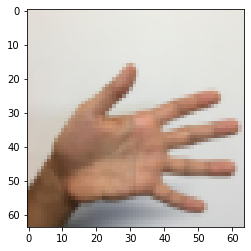

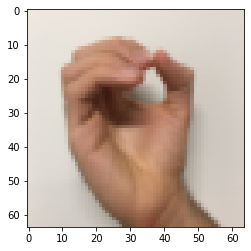

In [ ]:
imshow(X_train_orig[0])
plt.show()
imshow(X_train_orig[1]);

In [ ]:
model.fit(X_train, Y_train, epochs = 20, batch_size = 32)

Epoch 1/20
34/34 [==============================] - 13s 149ms/step - loss: 1.8875 - accuracy: 0.4593
Epoch 2/20
34/34 [==============================] - 4s 131ms/step - loss: 0.4828 - accuracy: 0.8324
Epoch 3/20
34/34 [==============================] - 4s 131ms/step - loss: 0.3361 - accuracy: 0.8843
Epoch 4/20
34/34 [==============================] - 4s 131ms/step - loss: 0.2659 - accuracy: 0.9148
Epoch 5/20
34/34 [==============================] - 4s 131ms/step - loss: 0.5883 - accuracy: 0.8500
Epoch 6/20
34/34 [==============================] - 4s 131ms/step - loss: 1.1407 - accuracy: 0.7259
Epoch 7/20
34/34 [==============================] - 4s 131ms/step - loss: 0.8213 - accuracy: 0.7917
Epoch 8/20
34/34 [==============================] - 4s 132ms/step - loss: 0.3210 - accuracy: 0.8907
Epoch 9/20
34/34 [==============================] - 4s 131ms/step - loss: 0.1479 - accuracy: 0.9602
Epoch 10/20
34/34 [==============================] - 4s 131ms/step - loss: 0.1360 - accuracy: 0.960


Congratulations on finishing this assignment! You've now implemented a state-of-the-art image classification system! Woo hoo!

ResNet50 is a powerful model for image classification when it's trained for an adequate number of iterations. Hopefully, from this point, you can use what you've learned and apply it to your own classification problem to perform state-of-the-art accuracy.



What you should remember:

    Very deep "plain" networks don't work in practice because vanishing gradients make them hard to train.
    Skip connections help address the Vanishing Gradient problem. They also make it easy for a ResNet block to learn an identity function.
    There are two main types of blocks: The identity block and the convolutional block.
    Very deep Residual Networks are built by stacking these blocks together.




In [ ]:
model.save(path+"resnet50.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
model = tf.keras.models.load_model(path+'resnet50.h5')

In [ ]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 2s 64ms/step - loss: 0.1073 - accuracy: 0.9750
Loss = 0.10733150690793991
Test Accuracy = 0.9750000238418579


## 5 - Test on Your Own Image

If you wish, you can also take a picture of your own hand and see the output of the model. 

Input image shape: (1, 64, 64, 3)
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] =  [[0.539 0.002 0.002 0.217 0.2   0.04 ]]
Class: 0


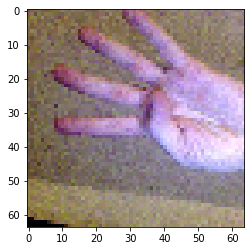

In [ ]:
img_path = path+'my_hands/four.jpg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.0
print('Input image shape:', x.shape)
imshow(img)
prediction = model.predict(x)
print("Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ", np.round(prediction,3))
print("Class:", np.argmax(prediction))

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_67 (Conv2D)              (None, 32, 32, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
batch_normalization_67 (BatchNo (None, 32, 32, 64)   256         conv2d_67[0][0]                  
____________________________________________________________________________________________

## 6 - Bibliography

This notebook presents the ResNet algorithm from He et al. (2015). The implementation here also took significant inspiration and follows the structure given in the GitHub repository of Francois Chollet:

    Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun - Deep Residual Learning for Image Recognition (2015)
    Francois Chollet's GitHub repository: https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py
